<a href="https://colab.research.google.com/github/dipayandas97/Deep-Learning-Notebooks/blob/master/Molecule_generation_using_Adversarial_AutoEncoder_with_Teacher_forcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [0]:
import sys

sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold as msc
from rdkit.Chem import Draw, Descriptors

In [0]:
msc.MurckoScaffoldSmilesFromSmiles('Cc1cc(Oc2nccc(CCC)c2)ccc1')

'c1ccc(Oc2ccccn2)cc1'

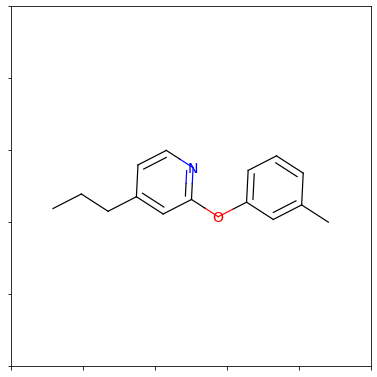

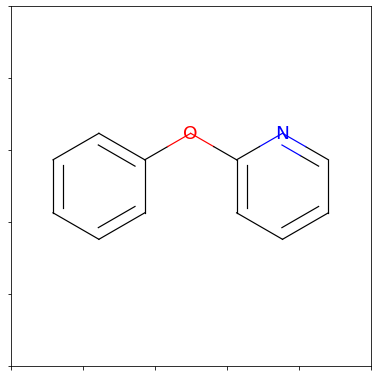

In [0]:
mol = Chem.MolFromSmiles('Cc1cc(Oc2nccc(CCC)c2)ccc1')
Draw.MolToMPL(mol, size=(200,200)) 
mol = Chem.MolFromSmiles('c1ccc(Oc2ccccn2)cc1')
Draw.MolToMPL(mol, size=(200,200)) 
plt.show()

In [0]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

#drive.mount('/content/drive/')

2.2.0-rc3


In [0]:
X = np.load('/content/drive/My Drive/ISI/DRUG/Preprocessed_data/GDB17_3.3m.npy')

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size = 0.66, shuffle = True)
print(X_train.shape, X_test.shape)
del X

(1288928, 55, 31) (2502039, 55, 31)


In [0]:
y_train = np.zeros((X_train.shape[0],X_train.shape[1],X_train.shape[2]), dtype=np.int8)
y_train[:,:-1,:] = X_train[:,1:,:]
y_train[:,-1,:] = X_train[:,-1,:]

'''
y_test = np.zeros((X_test.shape[0],X_test.shape[1],X_test.shape[2]), dtype=np.int8)
y_test[:,:-1,:] = X_test[:,1:,:]
y_test[:,-1,:] = X_test[:,-1,:]
'''

'\ny_test = np.zeros((X_test.shape[0],X_test.shape[1],X_test.shape[2]), dtype=np.int8)\ny_test[:,:-1,:] = X_test[:,1:,:]\ny_test[:,-1,:] = X_test[:,-1,:]\n'

In [0]:
#Import Keras objects
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import *
from tensorflow.keras.optimizers import Adam

latent_dim = 56
lstm_dim = 128

#encoder
encoder_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder_outputs, state_h, state_c = LSTM(lstm_dim, return_state=True)(encoder_input)
states = Concatenate(axis=-1)([state_h, state_c])
latent = Dense(latent_dim)(states)
latent = LayerNormalization(axis=-1)(latent)

encoder = Model(encoder_input, latent)

#decoder
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded = decode_h(latent)
state_c_decoded = decode_c(latent)

encoder_states = [state_h_decoded, state_c_decoded]

decoder_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
d = LSTM(lstm_dim, return_sequences=True)(decoder_input, initial_state=encoder_states)
decoded_output = Dense(X_train.shape[-1], activation='softmax')(d)

#Discriminator
disc_input = Input(shape=(latent_dim,))
d = Dense(32)(disc_input)
d = ELU()(d)
d = Dense(16)(d)
d = ELU()(d)
d = Dense(1, activation='sigmoid')(d)
discriminator = Model(disc_input, d)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

disc_output = discriminator(latent)

#Adversarial Autoencoder
AAE = Model([encoder_input, decoder_input], [decoded_output, disc_output])
AAE.compile(optimizer='adam', loss=['mse','binary_crossentropy'], loss_weights=[1,0.017])

#print(encoder.summary(), decoder.summary(), AE.summary(), discriminator.summary(), AAE.summary())

In [0]:
AAE.summary()

In [0]:
disc_loss = []
recon_loss = []
val_loss = []

In [0]:
from tqdm.notebook import tqdm as tqdm
import pickle
f = open('/content/drive/My Drive/ISI/DRUG/Preprocessed_data/dictionaries.pkl', 'rb')
dictionaries = pickle.load(f)
f.close()
char_to_int = dictionaries[0]
int_to_char = dictionaries[1]

#filepath = '/content/drive/My Drive/ISI/DRUG/GDB17_TF_AAE_weights_4.h5'
#AAE.load_weights(filepath)

train_data = X_train

batches = 500
batch_size = 512
epochs = 30
#min_loss = 9999

real_label = np.ones((batch_size,1))
fake_label = np.zeros((batch_size,1))

for e in range(epochs):
    print('Epoch:',(e+1),'/',epochs,'------------------------------------------------------------------------------------------------')

    b_disc_loss = []
    b_recon_loss = []
    b_val_loss = []
    b=0 #batch counter

    for _ in tqdm(range(batches)):
        b+=1 
        ids = np.random.randint(0, train_data.shape[0], batch_size)
        signals = train_data[ids]
        y_signals = y_train[ids]

        latent_fake = encoder(signals)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        if b%7 == 0: #Train discriminator after every 10th mini batch training of the generator 
            #Train discriminator----------------------------------------------
            discriminator.trainable = True

            loss_real = discriminator.train_on_batch(latent_real, real_label)
            loss_fake = discriminator.train_on_batch(latent_fake, fake_label)
            d_loss = np.add(loss_real, loss_fake) * 0.5
            b_disc_loss.append(d_loss[1])

            discriminator.trainable = False

        #Train entire AAE-------------------------------------------------
        a_loss = AAE.train_on_batch([signals,signals], [y_signals,real_label])

        #Validation
        train_loss = AAE.test_on_batch([signals,signals], [y_signals, real_label])
        b_recon_loss.append(train_loss[1])
        b_val_loss.append(train_loss[0])
        
    disc_loss.append(np.mean(b_disc_loss))
    recon_loss.append(np.mean(b_recon_loss))
    val_loss.append(np.mean(b_val_loss))

    print('Discriminator: %.2f'%(disc_loss[-1]*100),'% ||', 'Validation_LOSS: Recon: %.6f'%recon_loss[-1],'|', 'Reg. Loss: %.8f'%(val_loss[-1]-recon_loss[-1]),'\n')
    
    #Example output
    i = np.random.randint(0,X_test.shape[0],2)[0:1]
    v = AAE.predict([X_test[i],X_test[i]])                                                                                                                         
    idxs = np.argmax(v[0], axis=2)
    pred =  "".join([int_to_char[h] for h in idxs[0]])
    print('Pred: ',pred,'\n')
    #save last best model
    if recon_loss[-1] < min_loss:
        print('Recon. Loss improved from',min_loss,'to',recon_loss[-1])
        min_loss = recon_loss[-1]
        AAE.save_weights(filepath)


Epoch: 1 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001619 | Reg. Loss: 0.00000013 

Pred:  CC12CC=CCC1(CCC(NCC=O)C11CXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0016421088660135866 to 0.0016194524569436907
Epoch: 2 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001612 | Reg. Loss: 0.00000014 

Pred:  CC1OCC(C)(CCC=O)CC1C11(C)C#C)O2XXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0016194524569436907 to 0.0016118722863029688
Epoch: 3 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001594 | Reg. Loss: 0.00000012 

Pred:  CCOCNC(CNC=N)CC(C)(C)C=C1XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0016118722863029688 to 0.0015938247020822018
Epoch: 4 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001525 | Reg. Loss: 0.00000018 

Pred:  CC1=CC2=CCC(=O)CC2CC1CC2=NOXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0015938247020822018 to 0.0015249409116804599
Epoch: 5 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001509 | Reg. Loss: 0.00000019 

Pred:  CC1=CNC2=C1CC(=2)=NC1=NC(C(O1)C#CXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0015249409116804599 to 0.0015086165396496654
Epoch: 6 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001457 | Reg. Loss: 0.00000041 

Pred:  CCCC#C((=O)(=O)CC1=NC(=O)N==C1XXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0015086165396496654 to 0.0014568168390542268
Epoch: 7 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 49.99 % || Validation_LOSS: Recon: 0.001495 | Reg. Loss: 0.00000018 

Pred:  CC1=C2CCC(C2)O(O)C(N)=C1))C(C)(C)NXXXXXXXXXXXXXXXXXXXXX 

Epoch: 8 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001397 | Reg. Loss: 0.00000011 

Pred:  CCO1(C)CCNC2C(C)CNC2(C)C1COXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0014568168390542268 to 0.0013973025127779692
Epoch: 9 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001410 | Reg. Loss: 0.00000015 

Pred:  CCCC(N)C1C(C)CCNCNC2CC123XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Epoch: 10 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001362 | Reg. Loss: 0.00000015 

Pred:  CCN1C(C)=CN=C1C(C)CC(C)(C)C(N)=NXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0013973025127779692 to 0.0013618198307231068
Epoch: 11 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001350 | Reg. Loss: 0.00000009 

Pred:  CC1COC2((=O)CC(C)(CC#C)C2(O)C1XXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0013618198307231068 to 0.0013503700625151396
Epoch: 12 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001326 | Reg. Loss: 0.00000012 

Pred:  CCC(=O)C1=CC2=C(C)C(O)=C(N)N=C=C1CXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0013503700625151396 to 0.0013258542369585485
Epoch: 13 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001314 | Reg. Loss: 0.00000019 

Pred:  CCCCN=C1C=CNC(C)=C1NC(=N)C#CXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0013258542369585485 to 0.0013140999313909561
Epoch: 14 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001271 | Reg. Loss: 0.00000017 

Pred:  CCC12O3((C)C11C(C)C=CC23CXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0013140999313909561 to 0.0012709001797484233
Epoch: 15 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001290 | Reg. Loss: 0.00000012 

Pred:  CC12CCC(N1)C(=OO)C1=C(O2)SC(=O)S1XXXXXXXXXXXXXXXXXXXXXX 

Epoch: 16 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001216 | Reg. Loss: 0.00000016 

Pred:  CCC1OC2(CC1(CC)OC2C)C1=CSC=C1XXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0012709001797484233 to 0.0012164431570563464
Epoch: 17 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001153 | Reg. Loss: 0.00000018 

Pred:  CC1CN(C=N1)C1(C)CC(N)CC2CCCC12XXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0012164431570563464 to 0.0011525952334050088
Epoch: 18 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001146 | Reg. Loss: 0.00000014 

Pred:  CCC(C)(O)C1=C2C(NC)=NC2C2C(F)=CN1XXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0011525952334050088 to 0.0011459377746796235
Epoch: 19 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001148 | Reg. Loss: 0.00000015 

Pred:  CCC1OC(C)C=CC2(CNN=(=O)(=O)C1C2CXXXXXXXXXXXXXXXXXXXXXXX 

Epoch: 20 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001103 | Reg. Loss: 0.00000016 

Pred:  CC1CC2(C)C3CCC3OC2CCCNCCXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0011459377746796235 to 0.001102696722955443
Epoch: 21 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001082 | Reg. Loss: 0.00000015 

Pred:  CCC(CCC(N)=N)C(=O)C(C)(CC)C(=)=NXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.001102696722955443 to 0.001081586770596914
Epoch: 22 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001093 | Reg. Loss: 0.00000017 

Pred:  CCC(C)(C(C)NC(N)=NC)C1=CN==C1CXXXXXXXXXXXXXXXXXXXXXXXXX 

Epoch: 23 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001040 | Reg. Loss: 0.00000015 

Pred:  CCC(=O)CC(C=O)C(O)(CC)C(C)(O)CCXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.001081586770596914 to 0.0010395660109352321
Epoch: 24 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.000998 | Reg. Loss: 0.00000020 

Pred:  CCC1=C(C)N=C(Or)C2=C1C(CCCNN)=NS2XXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0010395660109352321 to 0.0009980984631692991
Epoch: 25 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.001027 | Reg. Loss: 0.00000015 

Pred:  CCC(O)C1=CC2=C(C=C(SC=N2)C#C)C1=OXXXXXXXXXXXXXXXXXXXXXX 

Epoch: 26 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.000996 | Reg. Loss: 0.00000014 

Pred:  CCC(O)C12CC(CO(OOC(=N)O1)C(=O)C2CXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0009980984631692991 to 0.0009959657111903652
Epoch: 27 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.000956 | Reg. Loss: 0.00000015 

Pred:  CCC1(C)CN2C(=N)OC3=C2N1CCC3XXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0009959657111903652 to 0.0009559572528814897
Epoch: 28 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.000958 | Reg. Loss: 0.00000014 

Pred:  CCC1C(O)CC2CC(O)C(C)C1(N2)C(C)CXXXXXXXXXXXXXXXXXXXXXXXX 

Epoch: 29 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.000921 | Reg. Loss: 0.00000016 

Pred:  CC(NC1=CC(F)=C2N=CC=C2O1)CC#C)C#NXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0009559572528814897 to 0.0009209811390610412
Epoch: 30 / 30 ------------------------------------------------------------------------------------------------



Discriminator: 50.00 % || Validation_LOSS: Recon: 0.000870 | Reg. Loss: 0.00000013 

Pred:  CCC1COCOC1CC(CC(=O)C=O)OCXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

Recon. Loss improved from 0.0009209811390610412 to 0.000869953099405393


#Testing

##Setup 1

filepath = '/content/drive/My Drive/ISI/DRUG/GDB17_TF_AAE_weights_2.h5'
- loss weights : [1,0.01]
- 100 epochs w/ critic training after every 10 mini batches
- 50 epochs w/ critic training after every 20 mini batches
Result
- 94% reconstruction accuracy of 100 test data
- some latent vectors are not regularized with mean = 0, though all have unit variance. This happened after the 100 epochs when critic training was reduced by half. So the critic might not have coped up.

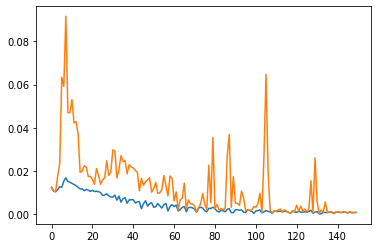

In [0]:
#plt.plot(range(len(disc_loss)), disc_loss)
plt.plot(range(len(recon_loss)), recon_loss)
plt.plot(range(len(val_loss)), val_loss)

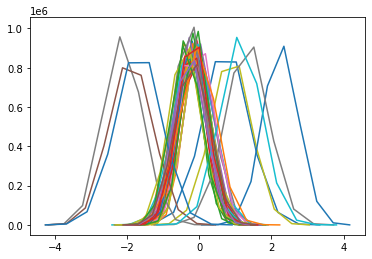

In [0]:
v = encoder.predict(X_test)
for i in range(latent_dim):
    h = np.histogram(v[:,i])
    plt.plot(h[1][:-1],h[0])

In [0]:
latent_input = Input(latent_dim,)

#Reuse decode_h, decode_c layer
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])

In [0]:
[print(i,c) for i,c in enumerate(AAE.layers)]

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4b11739940>
1 <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f4b11739908>
2 <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f4b114dcb00>
3 <tensorflow.python.keras.layers.core.Dense object at 0x7f4b114dc7f0>
4 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4b003649b0>
5 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4b00327438>
6 <tensorflow.python.keras.layers.core.Dense object at 0x7f4b0031df98>
7 <tensorflow.python.keras.layers.core.Dense object at 0x7f4b0031d940>
8 <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f4b003276d8>
9 <tensorflow.python.keras.layers.core.Dense object at 0x7f4b002e4080>
10 <tensorflow.python.keras.engine.training.Model object at 0x7f4b001fde80>


[None, None, None, None, None, None, None, None, None, None, None]

In [0]:
inf_decoder_inputs = Input(batch_shape=(1, 1, X_train.shape[-1])) #input_shape[1] = length of character-set (Input-basically one timstep of piano-roll)

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=False,
                    stateful=True #important
                   )

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs) #output shape : (?,1,lstm_dim)
inf_decoder_dense = Dense(X_train.shape[-1], activation='softmax') #FC converts it to (?,1,len_of_character_set)
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(AAE.layers[i+7].get_weights())

sample_model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(1, 1, 31)]              0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 128)               81920     
_________________________________________________________________
dense_8 (Dense)              (1, 1, 31)                3999      
Total params: 85,919
Trainable params: 85,919
Non-trainable params: 0
_________________________________________________________________


Latent to molecule #Important

In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]]) #put in thought vector
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,X_train.shape[-1]))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(X_train.shape[-2]):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "X":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,X_train.shape[-1]))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [0]:
c, w = 0,0
for i in range(100):
    #True string
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])
    u = true.index('X')
    true = true[:u]
    #pred
    x_latent = encoder(X_test[i:i+1])
    pred = latent_to_smiles(x_latent)
    print(true,'              ||               ',pred)
    if true[1:] == pred:
        c+=1
    else:
        w+=1
print('Correct: ',c,' Wrong: ',w )

!CC(O)C#CCCC1=CC(C)CC1(O)C=O               ||                CC(O)C#CCCC1=CC(C)CC1(O)C=O
!CC1C2C=C(C)C(=O)C1(C#N)C(=O)C1OC21               ||                CC1C2C=C(C)C(=O)C1(C#N)C(=O)C1OC21
!CCC1=C2C(OCC3NCCCCC23C)=CN1               ||                CCC1=C2C(OCC3NCCCCC23C)=CN1
!CC(=O)CCC1=C2N=NSC(=O)N=C2C(C)=N1               ||                CC(=O)CCC1=C2N=NSC(=O)N=C2C(C)=N1
!CC#CC1N(C)C2COC1(CO)CCC2               ||                CC#CC1N(C)C2COC1(CO)CCC2
!CCC12OCOC1C(NC1CC1)=NCC2C               ||                CCC12OCOC(C1NC1CC1)=NCC2C
!CC(C)C1CC2OCOC3(C=O)C(C)OC1C23               ||                CC(C)C1CC2OCOC3(C=O)C(C)OC1C23
!CCC1=C(C#CCN)C2NC3C2C1CC3C               ||                CCC1=C(C#CCN)C2NC3C2C1CC3C
!CCC(=O)C(OC1=CSN=C1)C1(C)OCCO1               ||                CCC(=O)C(OC1=CSN=C1)C1(C)OCCO1
!CC1=C(C)C23C4C5CCC(OC2=N5)C34CC1               ||                CC1=C(C)C23C4C5CCC(OC2=N5)C34CC1
!CCC1=CSC2=C1C1CC2S(=O)(=O)C1CCO               ||                CCC1=CSC2

##Setup 2

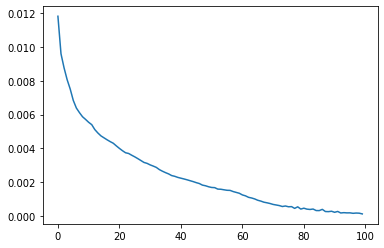

In [0]:
#plt.plot(range(len(disc_loss)), disc_loss)
#Reconstruction loss
plt.plot(range(len(recon_loss)), recon_loss)

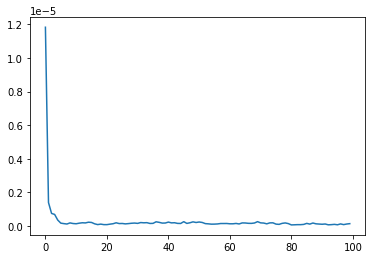

In [0]:
#Regularization loss
plt.plot(range(len(val_loss)), [x-y for x,y in zip(val_loss,recon_loss)])

In [0]:
latent_input = Input(latent_dim,)

#Reuse decode_h, decode_c layer
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 56)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          7296        input_8[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          7296        input_8[0][0]                    
Total params: 14,592
Trainable params: 14,592
Non-trainable params: 0
__________________________________________________________________________________________________


In [0]:
[print(i,c) for i,c in enumerate(AAE.layers)]

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f881e78eb70>
1 <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f881e78eb38>
2 <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f881df476d8>
3 <tensorflow.python.keras.layers.core.Dense object at 0x7f881df47b00>
4 <tensorflow.python.keras.layers.normalization.LayerNormalization object at 0x7f881013ccc0>
5 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f87f64089e8>
6 <tensorflow.python.keras.layers.core.Dense object at 0x7f87f64084e0>
7 <tensorflow.python.keras.layers.core.Dense object at 0x7f87f6408550>
8 <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f87f6408c88>
9 <tensorflow.python.keras.layers.core.Dense object at 0x7f87f6381eb8>
10 <tensorflow.python.keras.engine.training.Model object at 0x7f87f62fe2b0>


[None, None, None, None, None, None, None, None, None, None, None]

In [0]:
inf_decoder_inputs = Input(batch_shape=(1, 1, X_train.shape[-1])) #input_shape[1] = length of character-set (Input-basically one timstep of piano-roll)

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=False,
                    stateful=True #important
                   )

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs) #output shape : (?,1,lstm_dim)
inf_decoder_dense = Dense(X_train.shape[-1], activation='softmax') #FC converts it to (?,1,len_of_character_set)
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(AAE.layers[i+7].get_weights())

sample_model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(1, 1, 31)]              0         
_________________________________________________________________
lstm_5 (LSTM)                (1, 1, 128)               81920     
_________________________________________________________________
dense_10 (Dense)             (1, 1, 31)                3999      
Total params: 85,919
Trainable params: 85,919
Non-trainable params: 0
_________________________________________________________________


Latent to molecule #Important

In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]]) #put in thought vector
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,X_train.shape[-1]))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(X_train.shape[-2]):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "X":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,X_train.shape[-1]))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [0]:
c, w = 0,0
for i in range(100):
    #True string
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])
    u = true.index('X')
    true = true[1:u]
    #pred
    x_latent = encoder(X_test[i:i+1])
    pred = latent_to_smiles(x_latent)
    print(true,'              ||               ',pred)
    if true == pred:
        c+=1
    else:
        w+=1
print('Correct: ',c,' Wrong: ',w )

CCCC1OC2C3COCC3C(OC1C)C2=O               ||                CCCC1OC2C3COCC3C(OC1C)C2=O
CC1=C2C(C=C1O)=C(O)C1=NC(N)=CON=C21               ||                CC1=C2C(C=C1O)=C(O)C1=NC(N)=CON=C21
CCN1C2CNC3C(C)C(CCC123)C(C)=O               ||                CCN1C2CNC3C(C)C(CCC123)C(C)=O
CCC12CC(C1)CC(COC2)NC               ||                CCC12CC(C1)CC(COC2)NC
CC1=C2CCC1C1CC(N1)C1=CCCOC21               ||                CC1=C2CCC1C1CC(N1)C1=CCCOC21
CCC1OC(C)C2(COC3C(C)NC23)C1C               ||                CCC1OC(C)C2(COC3C(C)NC23)C1C
CCC1=NC(C)=C(C2CC2)C2=C1S(=O)(=O)CC2               ||                CCC1=NC(C)=C(C2CC2)C2=C1S(=O)(=O)CC2
CC1COCC(C)C(C)(C1)OC1=C(O)N=CN1               ||                CC1COCC(C)C(C)(C1)OC1=C(O)N=CN1
CC1CC(=N)OC2(C1)OCC1=CN=CN1C2C               ||                CC1CC(=N)OC2(C1)OCC1=CN=CN1C2C
CC1=CC2=C(C=C1)C=C(NCC=O)C(Br)=C2O               ||                CC1=CC2=C(C=C1)C=C(NCC=O)C(Br)=C2O
CC(O)CCC1C(CO)C(C)C(C)C1C(C)C               ||                CC

array([ 5.44205494e-03, -1.87708549e-02,  1.10020898e-02, -4.67205122e-02,
        6.59935549e-03,  1.39928404e-02,  4.89073731e-02,  1.12856887e-02,
       -9.74505953e-03, -4.73053515e-04,  1.32836699e-02,  8.74799956e-03,
       -4.57193889e-03,  1.39407497e-02,  3.10141368e-05,  4.41243127e-03,
        2.77455635e-02, -3.04857641e-02,  1.77105702e-02, -1.16046937e-02,
        1.46630649e-02,  3.99686629e-03, -1.56198359e+01,  6.41602576e-02,
       -3.21449619e-03,  1.94063392e-02,  3.04152034e-02,  1.35416277e-02,
        3.73959392e-02,  1.86219122e-02,  2.59294827e-02, -2.33401582e-02,
       -9.21057817e-03, -1.66041367e-02, -2.65980307e-02, -1.01070171e-02,
       -1.53282825e-02,  1.17446277e-02,  1.98313128e-02, -3.55250947e-02,
       -5.95915437e-01,  2.25104578e-02, -1.98580548e-02, -5.48826810e-03,
       -2.94077862e-03, -1.01865781e-02, -2.00877693e-02,  4.31651075e-04,
       -3.35223274e-03, -1.58434473e-02, -5.21418154e-02, -1.86501015e-02,
       -6.51340261e-02, -

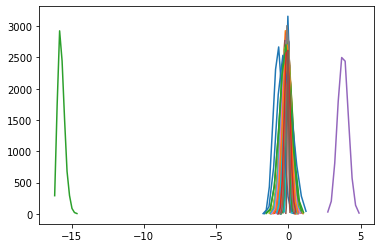

In [0]:
v = encoder.predict(X_test[10000:20000])
for i in range(latent_dim):
    h = np.histogram(v[:,i])
    plt.plot(h[1][:-1],h[0])
np.mean(v, axis=0)

Generating novel molecules

(56,)

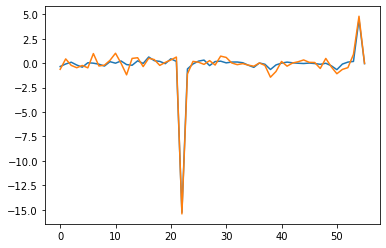

In [0]:
v = encoder.predict(X_test[0:1])[0]
plt.plot(range(len(v)),v)
n = (initial + np.random.normal(loc=0, scale=0.5,size=v.shape))
plt.plot(range(len(v)), n)
n.shape

In [0]:
valid = 0
unique = 0
my_mols = []

initial = encoder.predict(X_test[0:1])[0]

for i in range(100):
    n = (initial + np.random.normal(loc=0, scale=0.5,size=v.shape))
    smiles = latent_to_smiles(n.reshape(1,latent_dim))
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid+=1
        u = True
        for i in range(X_train.shape[0]):
            #True smiles
            idxs2 = np.argmax(X_train[i:i+1], axis=2)
            true =  "".join([int_to_char[k] for k in idxs2[0]])
            u = true.index('X')
            true = true[1:u]

            if smiles == true:
                u = False
                break
        if u: 
            unique+=1
            print('Unique: ', smiles)
            my_mols.append(smiles)
            
    print('Valid: ',valid,' Unique: ',unique)
print('Total -- Valid:',valid,' Unique:',unique,' Garbage:',(1000-valid))

Valid:  0  Unique:  0
Unique:  CCC1COCOCOCOOCOC11CC1CCCC
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Unique:  CCCCNC1CC1OC(CCO)OCCC1=NN1
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Unique:  CC1CCC1CC1=CC2C(O2)C(SC#CB1)O
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3 

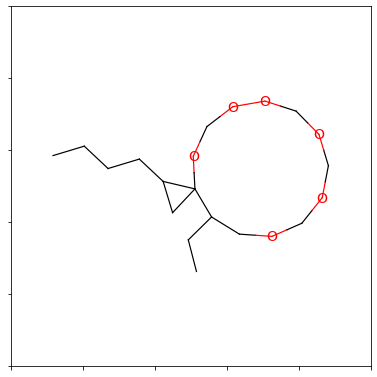

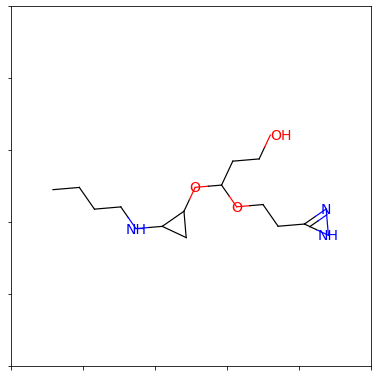

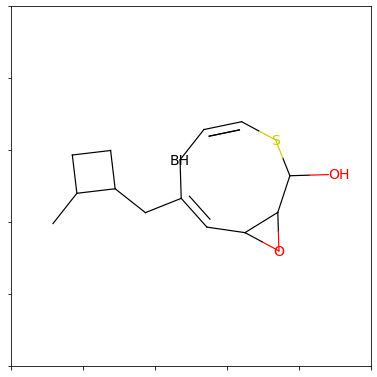

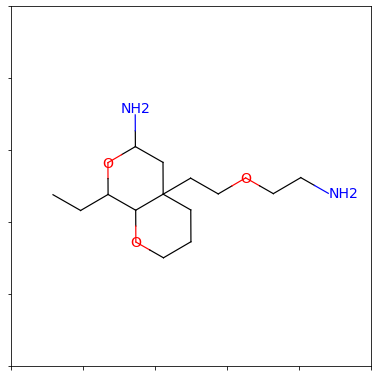

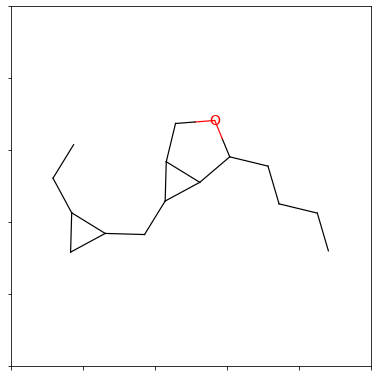

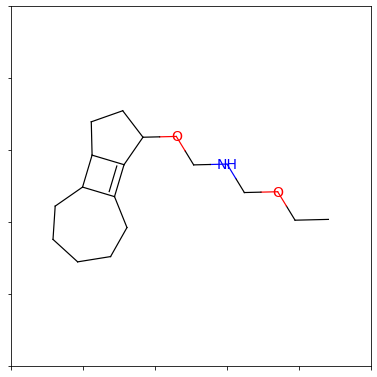

In [0]:
for m in my_mols:
    mol = mol = Chem.MolFromSmiles(m)
    Draw.MolToMPL(mol, size=(200,200)) 

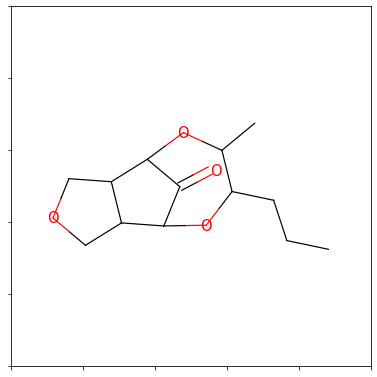

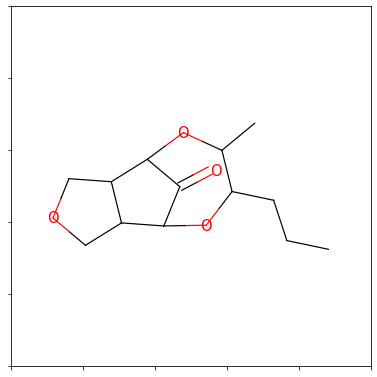

In [0]:
init = encoder.predict(X_test[0:1])
smiles = latent_to_smiles(init)
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol, size=(200,200)) 

##Setup 3

weight 3
- loss weights : [1, 0.017]
- discriminator trained after every 7 batches
- 100+30 epochs

In [0]:
filepath = '/content/drive/My Drive/ISI/DRUG/GDB17_TF_AAE_weights_3.h5'
AAE.load_weights(filepath)

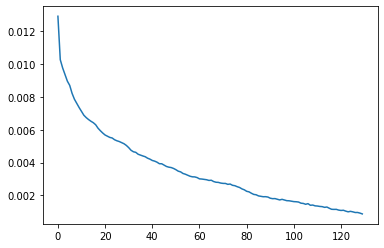

In [0]:
#plt.plot(range(len(disc_loss)), disc_loss)
#Reconstruction loss
plt.plot(range(len(recon_loss)), recon_loss)

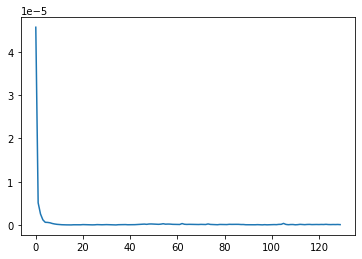

In [0]:
#Regularization loss
plt.plot(range(len(val_loss)), [x-y for x,y in zip(val_loss,recon_loss)])

In [0]:
latent_input = Input(latent_dim,)

#Reuse decode_h, decode_c layer
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 56)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          7296        input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          7296        input_4[0][0]                    
Total params: 14,592
Trainable params: 14,592
Non-trainable params: 0
__________________________________________________________________________________________________


In [0]:
[print(i,c) for i,c in enumerate(AAE.layers)]

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe37f2f5978>
1 <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fe37f2f5940>
2 <tensorflow.python.keras.layers.merge.Concatenate object at 0x7fe37f0854a8>
3 <tensorflow.python.keras.layers.core.Dense object at 0x7fe37f0858d0>
4 <tensorflow.python.keras.layers.normalization.LayerNormalization object at 0x7fe3701a6e10>
5 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe3701277b8>
6 <tensorflow.python.keras.layers.core.Dense object at 0x7fe3701272b0>
7 <tensorflow.python.keras.layers.core.Dense object at 0x7fe370127320>
8 <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7fe370127a58>
9 <tensorflow.python.keras.layers.core.Dense object at 0x7fe3700a6e48>
10 <tensorflow.python.keras.engine.training.Model object at 0x7fe370014fd0>


[None, None, None, None, None, None, None, None, None, None, None]

In [0]:
inf_decoder_inputs = Input(batch_shape=(1, 1, X_train.shape[-1])) #input_shape[1] = length of character-set (Input-basically one timstep of piano-roll)

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=False,
                    stateful=True #important
                   )

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs) #output shape : (?,1,lstm_dim)
inf_decoder_dense = Dense(X_train.shape[-1], activation='softmax') #FC converts it to (?,1,len_of_character_set)
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(AAE.layers[i+7].get_weights())

sample_model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(1, 1, 31)]              0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 128)               81920     
_________________________________________________________________
dense_7 (Dense)              (1, 1, 31)                3999      
Total params: 85,919
Trainable params: 85,919
Non-trainable params: 0
_________________________________________________________________


Latent to molecule #Important

In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]]) #put in thought vector
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,X_train.shape[-1]))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(X_train.shape[-2]):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "X":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,X_train.shape[-1]))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [0]:
c, w = 0,0
for i in range(100):
    #True string
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])
    u = true.index('X')
    true = true[1:u]
    #pred
    x_latent = encoder(X_test[i:i+1])
    pred = latent_to_smiles(x_latent)
    print(true,'              ||               ',pred)
    if true == pred:
        c+=1
    else:
        w+=1
print('Correct: ',c,' Wrong: ',w )

CCC1(O)COCC2(C)OC1C(C)OC(=O)O2               ||                CCC1(O)COCC2(C)OC1C(C)(C2)C#N
CCN1C2CC3=CCCC(CCC3C12)=NO               ||                CCN1C2CC3=CCCC(CCC2C1N)=N3
CC1CC1C1(C)CC2(CN)CN1CC(C)=C2               ||                CC1CC1C1(C)CC2(CN)C2C1(OC#C)N
CC(O)C(CCC1OC(C)=NC1C)C(C)C=O               ||                CC(O)C(CCC1OC(C)=NC1C)C(C)C=O
CCC12OC=NC1C1C(C)N1C2(CC)C=O               ||                CCC12OC=NC1C1C(C)N1C2(CC)C=O
CN1C2CC3OC(=O)C3C1(C)CCCC2               ||                CN1C2CC3OC(=O)C3C1(C)CCCC2
CCC1=C(C)C(=N)SC(=CC1=O)C(C)CC=O               ||                CCC1=C(C)C(=N)SC(=CC1=O)C(C)CC=O
CCC1CC(C)C2(CN=CN2C1)C1CCCN1               ||                CCC1CC(C)C2(CN=C2NC1)C1CCCN1
CC1=CC=C(F)C(CC2CCC(=O)C2CO)=N1               ||                CC1=CC=C(C)OC2CCC=CC(O)(C#C)N12
CC(C)C(C)C1(O)CC(=O)CCC1CC(O)=O               ||                CC(C)C(C)C1(O)CC(=O)CCC1CC(O)=O
CC(C1OC(C)CC(C)O1)N1CC(C)C1               ||                CC(C1OC(C)CC(C)O1)N1C

array([-4.11712285e-03,  9.81628057e-03,  1.43854169e-03,  1.73267897e-03,
        1.32410275e-02, -1.48599490e-03,  4.76706028e-03, -1.66025548e-03,
       -1.60574876e-02, -6.81274629e-04, -2.33154884e-03,  5.85237937e-03,
        2.82958150e-03, -8.57599732e-03,  8.34417582e-01,  1.48562470e-03,
        2.09371652e-03,  7.44948676e-03,  1.26571273e-02, -6.30818028e-03,
       -1.07891718e-02, -4.38791746e-03, -1.15346201e-02, -6.09860476e-03,
       -5.63052250e-04, -6.49495702e-03,  3.02434224e-03, -2.03253385e-02,
       -8.14516004e-03, -4.81793936e-03,  1.13852882e+01,  1.96637309e-04,
       -1.04443775e-02,  3.74641200e-03,  4.71415604e-03,  2.15379358e-03,
        1.00242160e-02, -1.33928738e-03, -6.27780100e-03, -5.24138054e-03,
       -5.04197359e+00, -9.84511338e-03,  1.44567168e+00, -2.73433421e-03,
        5.13948314e-03, -8.10972322e-03, -8.82596802e-03,  7.28815980e-03,
       -3.60187292e-01, -1.27090840e-02, -2.50006095e-03,  3.63260694e-03,
        7.28585152e-03, -

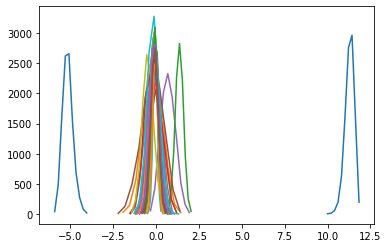

In [0]:
v = encoder.predict(X_test[10000:20000])
for i in range(latent_dim):
    h = np.histogram(v[:,i])
    plt.plot(h[1][:-1],h[0])
np.mean(v, axis=0)

Generating novel molecules

(56,)


(56,)

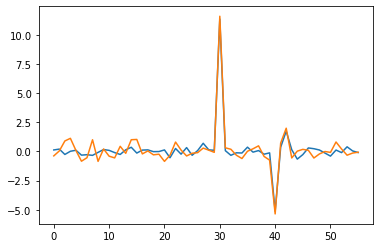

In [0]:
initial = encoder.predict(X_test[:100000])
initial = np.mean(initial, axis=0)
print(initial.shape)

v = encoder.predict(X_test[0:1])[0]
plt.plot(range(len(v)),v)
n = (initial + np.random.normal(loc=0, scale=0.5,size=v.shape))
plt.plot(range(len(v)), n)
n.shape

In [0]:
import pickle
f = open('/content/drive/My Drive/ISI/DRUG/Preprocessed_data/dictionaries.pkl', 'rb')
dictionaries = pickle.load(f)
f.close()
char_to_int = dictionaries[0]
int_to_char = dictionaries[1]

valid = 0
unique = 0
my_mols = []

initial = encoder.predict(X_train[:100000])
initial = np.mean(initial, axis=0)

for j in range(100):
    n = (initial + np.random.normal(loc=0, scale=0.3,size=v.shape))
    smiles = latent_to_smiles(n.reshape(1,latent_dim))
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid+=1
        u = True
        for i in range(X_train.shape[0]):
            #True smiles
            idxs2 = np.argmax(X_train[i:i+1], axis=2)
            true =  "".join([int_to_char[k] for k in idxs2[0]])
            u = true.index('X')
            true = true[1:u]

            if smiles == true:
                u = False
                break
        if u: 
            unique+=1
            print('Unique: ', smiles)
            my_mols.append(smiles)
            
    print(j, 'Valid: ',valid,' Unique: ',unique)
print('Total -- Valid:',valid,' Unique:',unique,' Garbage:',(1000-valid))

0 Valid:  0  Unique:  0
Unique:  CCOC1(CN)CNCC=C2C1=C(O)C(C)N2
1 Valid:  1  Unique:  1
Unique:  CC1CCOC2=C(C=CC=C(N)CC#C2)C1
2 Valid:  2  Unique:  2
Unique:  CCC1=C(C)C=CC2(OC1(C)C2)C(=N)NC
3 Valid:  3  Unique:  3
4 Valid:  3  Unique:  3
5 Valid:  3  Unique:  3
Unique:  CCC1=C(CC)CN(OC(C=C1)=O)C=NO
6 Valid:  4  Unique:  4
7 Valid:  4  Unique:  4
8 Valid:  4  Unique:  4
9 Valid:  4  Unique:  4
10 Valid:  4  Unique:  4
11 Valid:  4  Unique:  4
12 Valid:  4  Unique:  4
13 Valid:  4  Unique:  4
14 Valid:  4  Unique:  4
Unique:  CCC1C2=CCC(N)(CC=C1)C(C)N(C)2
15 Valid:  5  Unique:  5
16 Valid:  5  Unique:  5
Unique:  CC1C=C(C)C2=C1C(O)C(N)(C#CNC2)O
17 Valid:  6  Unique:  6
18 Valid:  6  Unique:  6
19 Valid:  6  Unique:  6
20 Valid:  6  Unique:  6
21 Valid:  6  Unique:  6
Unique:  CCN1CC(NC(OC2=C(CC=O)CC1)C)C2
22 Valid:  7  Unique:  7
23 Valid:  7  Unique:  7
Unique:  CCC1=CC(CO)C(=O)CCCN(C#C)C1=N
24 Valid:  8  Unique:  8
Unique:  CCC(O)C1N2CC2OC2C(=O)OC(C)OC2O1
25 Valid:  9  Unique:  9
26 Va

In [0]:
valid = 0
unique = 0
my_mols = []

initial = encoder.predict(X_test[0:1])[0]

for i in range(100):
    n = (initial + np.random.normal(loc=0, scale=0.3,size=v.shape))
    smiles = latent_to_smiles(n.reshape(1,latent_dim))
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid+=1
        u = True
        for i in range(X_train.shape[0]):
            #True smiles
            idxs2 = np.argmax(X_train[i:i+1], axis=2)
            true =  "".join([int_to_char[k] for k in idxs2[0]])
            u = true.index('X')
            true = true[1:u]

            if smiles == true:
                u = False
                break
        if u: 
            unique+=1
            print('Unique: ', smiles)
            my_mols.append(smiles)
            
    print(i, 'Valid: ',valid,' Unique: ',unique)
print('Total -- Valid:',valid,' Unique:',unique,' Garbage:',(1000-valid))

Valid:  0  Unique:  0
Valid:  0  Unique:  0
Valid:  0  Unique:  0
Valid:  0  Unique:  0
Valid:  0  Unique:  0
Valid:  0  Unique:  0
Unique:  CCC1OC(O)C=CC(O)C(C1C)C(F)=NO
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Valid:  1  Unique:  1
Unique:  CCCN1C(O)(CC)NC(OC(CC)C)CC1=NC
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Valid:  2  Unique:  2
Unique:  CCC(N1)CC(C1C)NC1CC1C1=NOC1CN
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Valid:  3  Unique:  3
Unique:  CCN1CC(C)(C(C)CN)C(CCCN)C1=NO
Valid:  4  Unique:  4
Valid:  4  Unique:  4
Valid:  4  Unique:  4
Valid:  4  Unique:  4
Unique:  CC1C(NC(COC1C)=O)CC(C(C)(C)C)C
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  Unique:  5
Valid:  5  

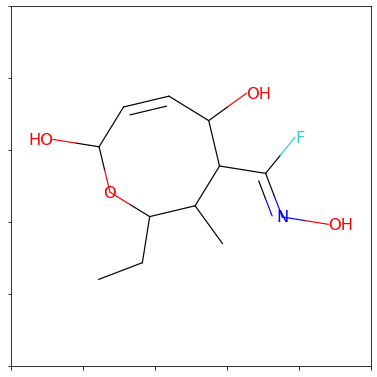

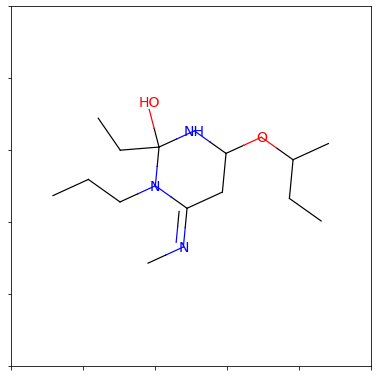

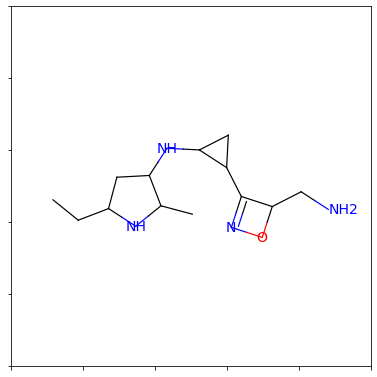

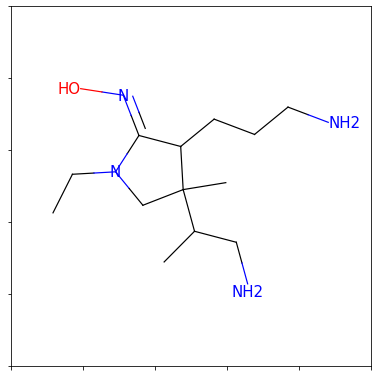

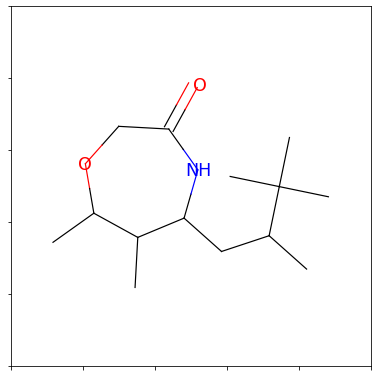

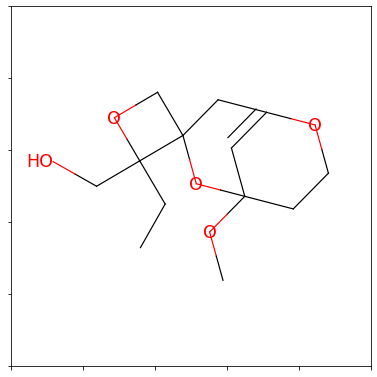

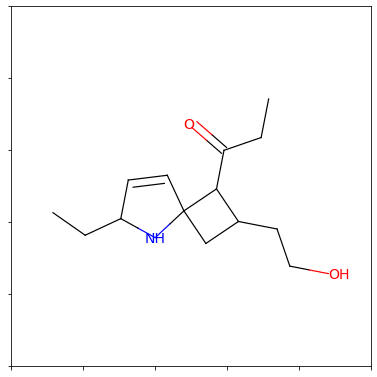

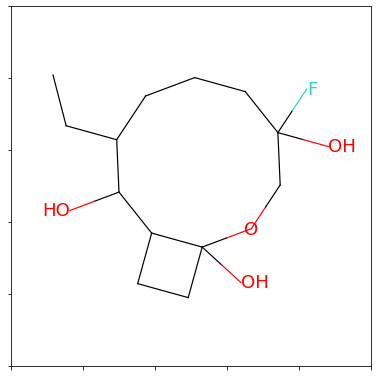

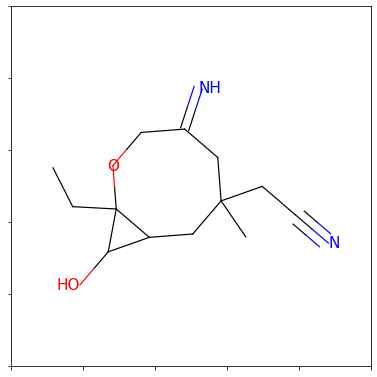

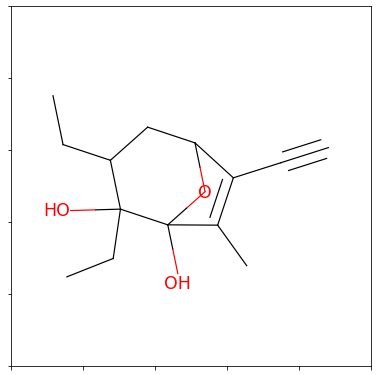

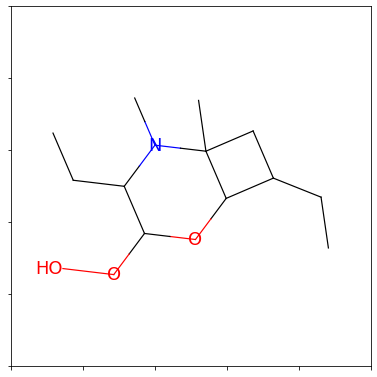

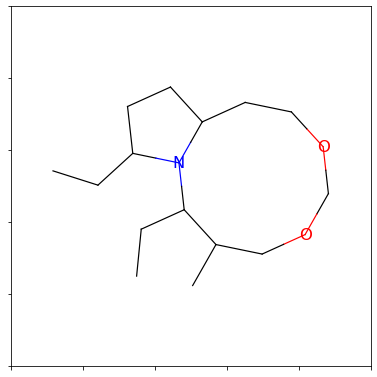

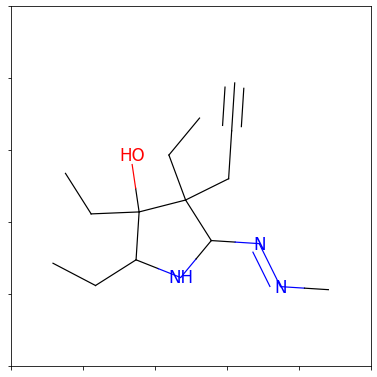

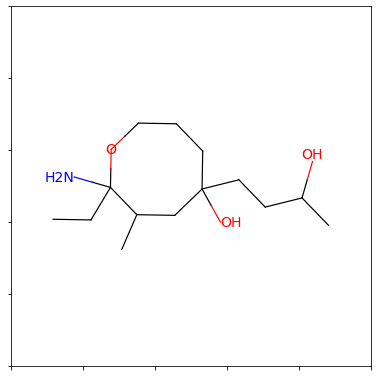

In [0]:
for m in my_mols:
    mol = mol = Chem.MolFromSmiles(m)
    Draw.MolToMPL(mol, size=(200,200)) 

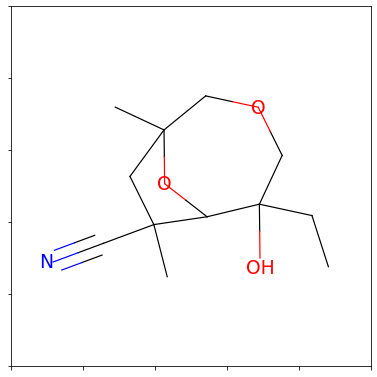

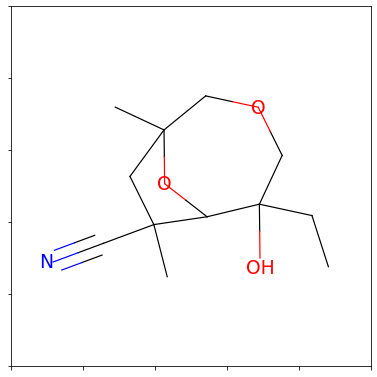

In [0]:
init = encoder.predict(X_test[0:1])
smiles = latent_to_smiles(init)
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol, size=(200,200)) 